In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [ ]:
class TextEDA:
    def __init__(self, df, text_column):
        """
        Initialize TextEDA with DataFrame and text column
        
        Args:
            df (pd.DataFrame): DataFrame containing text data
            text_column (str): Name of the text column to analyze
        """
        self.df = df.copy()
        self.text_column = text_column
        self.all_text = ' '.join(df[text_column].fillna('').astype(str))
        self.tokens = self.all_text.split()
        
    def get_word_frequency(self, top_n=20):
        """Get word frequency analysis"""
        word_freq = Counter(self.tokens)
        return word_freq.most_common(top_n)
    
    def get_ngrams(self, n=2, top_n=20):
        """
        Extract n-grams from text
        
        Args:
            n (int): Size of n-grams (2 for bigrams, 3 for trigrams)
            top_n (int): Number of top n-grams to return
        """
        # Create n-grams
        ngram_list = []
        for text in self.df[self.text_column].fillna(''):
            tokens = str(text).split()
            if len(tokens) >= n:
                ngram_list.extend(list(ngrams(tokens, n)))
        
        # Count n-grams
        ngram_freq = Counter(ngram_list)
        return ngram_freq.most_common(top_n)
    
    def plot_word_frequency(self, top_n=20, figsize=(12, 8)):
        """Plot word frequency bar chart"""
        word_freq = self.get_word_frequency(top_n)
        
        words, counts = zip(*word_freq)
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Bar plot
        ax1.barh(range(len(words)), counts, color='skyblue')
        ax1.set_yticks(range(len(words)))
        ax1.set_yticklabels(words)
        ax1.set_xlabel('Frequency')
        ax1.set_title(f'Top {top_n} Most Frequent Words')
        ax1.invert_yaxis()
        
        # Add value labels
        for i, count in enumerate(counts):
            ax1.text(count + max(counts)*0.01, i, str(count), 
                    va='center', fontweight='bold')
        
        # Pie chart for top 10
        top_10_words = words[:10]
        top_10_counts = counts[:10]
        
        ax2.pie(top_10_counts, labels=top_10_words, autopct='%1.1f%%', 
                startangle=90, colors=plt.cm.Set3(range(len(top_10_words))))
        ax2.set_title('Top 10 Words Distribution')
        
        plt.tight_layout()
        plt.show()
    
    def plot_ngrams(self, n=2, top_n=15, figsize=(14, 8)):
        """Plot n-grams analysis"""
        ngram_freq = self.get_ngrams(n, top_n)
        
        if not ngram_freq:
            print(f"No {n}-grams found in the text.")
            return
        
        # Prepare data
        ngram_labels = [' '.join(ngram) for ngram, _ in ngram_freq]
        ngram_counts = [count for _, count in ngram_freq]
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Bar plot
        bars = ax1.barh(range(len(ngram_labels)), ngram_counts, 
                       color=plt.cm.viridis(np.linspace(0, 1, len(ngram_labels))))
        ax1.set_yticks(range(len(ngram_labels)))
        ax1.set_yticklabels(ngram_labels, fontsize=10)
        ax1.set_xlabel('Frequency')
        ax1.set_title(f'Top {top_n} Most Frequent {n}-grams')
        ax1.invert_yaxis()
        
        # Add value labels
        for i, count in enumerate(ngram_counts):
            ax1.text(count + max(ngram_counts)*0.01, i, str(count), 
                    va='center', fontweight='bold')
        
        # Network-style plot for relationships
        if n == 2:  # Only for bigrams
            # Create a simple network visualization
            from collections import defaultdict
            connections = defaultdict(int)
            
            for bigram, count in ngram_freq:
                word1, word2 = bigram
                connections[(word1, word2)] = count

            unique_words = list(set([word for bigram, _ in ngram_freq for word in bigram]))
            word_positions = {word: (i % 5, i // 5) for i, word in enumerate(unique_words)}
            
            for (word1, word2), count in connections.items():
                if word1 in word_positions and word2 in word_positions:
                    x1, y1 = word_positions[word1]
                    x2, y2 = word_positions[word2]
                    
                    # Draw line between connected words
                    ax2.plot([x1, x2], [y1, y2], 'b-', alpha=0.3, linewidth=count/max(ngram_counts)*3)
            
            # Plot word positions
            for word, (x, y) in word_positions.items():
                ax2.scatter(x, y, s=200, c='red', alpha=0.7)
                ax2.annotate(word, (x, y), xytext=(5, 5), textcoords='offset points', 
                           fontsize=8, ha='left')
            
            ax2.set_title('Bigram Network Visualization')
            ax2.set_xlabel('Network Position')
            ax2.set_ylabel('Network Position')
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def create_wordcloud(self, figsize=(15, 8), max_words=100):
        """Create word cloud visualization"""
        if not self.all_text.strip():
            print("No text available for word cloud generation.")
            return
        
        # Create word cloud
        wordcloud = WordCloud(
            width=800, 
            height=400,
            background_color='white',
            max_words=max_words,
            colormap='viridis',
            relative_scaling=0.5,
            random_state=42
        ).generate(self.all_text)
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Main word cloud
        axes[0, 0].imshow(wordcloud, interpolation='bilinear')
        axes[0, 0].set_title('Word Cloud - All Text', fontsize=14, fontweight='bold')
        axes[0, 0].axis('off')
        
        # Word cloud with different colormap
        wordcloud_cool = WordCloud(
            width=800, 
            height=400,
            background_color='black',
            max_words=max_words,
            colormap='cool',
            relative_scaling=0.5,
            random_state=42
        ).generate(self.all_text)
        
        axes[0, 1].imshow(wordcloud_cool, interpolation='bilinear')
        axes[0, 1].set_title('Word Cloud - Cool Theme', fontsize=14, fontweight='bold')
        axes[0, 1].axis('off')
        
        # Word frequency histogram
        word_freq = self.get_word_frequency(20)
        words, counts = zip(*word_freq)
        
        axes[1, 0].bar(range(len(words[:10])), counts[:10], color='skyblue')
        axes[1, 0].set_xticks(range(len(words[:10])))
        axes[1, 0].set_xticklabels(words[:10], rotation=45, ha='right')
        axes[1, 0].set_title('Top 10 Word Frequencies', fontsize=14, fontweight='bold')
        axes[1, 0].set_ylabel('Frequency')
        
        # Text length distribution
        text_lengths = self.df[self.text_column].fillna('').astype(str).str.len()
        axes[1, 1].hist(text_lengths, bins=20, color='lightcoral', alpha=0.7)
        axes[1, 1].set_title('Text Length Distribution', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Character Count')
        axes[1, 1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
    
    def comprehensive_analysis(self):
        """Run comprehensive EDA analysis"""
        print("=" * 60)
        print("COMPREHENSIVE TEXT EDA ANALYSIS")
        print("=" * 60)
        
        # Basic statistics
        total_texts = len(self.df)
        total_words = len(self.tokens)
        unique_words = len(set(self.tokens))
        avg_words_per_text = total_words / total_texts if total_texts > 0 else 0
        
        print(f"\n📊 BASIC STATISTICS:")
        print(f"Total texts: {total_texts:,}")
        print(f"Total words: {total_words:,}")
        print(f"Unique words: {unique_words:,}")
        print(f"Average words per text: {avg_words_per_text:.2f}")
        print(f"Vocabulary richness: {unique_words/total_words:.3f}")
        
        # Word frequency analysis
        print(f"\n📈 WORD FREQUENCY ANALYSIS:")
        self.plot_word_frequency(top_n=20)
        
        # Bigram analysis
        print(f"\n🔗 BIGRAM ANALYSIS:")
        self.plot_ngrams(n=2, top_n=15)
        
        # Trigram analysis
        print(f"\n🔗🔗 TRIGRAM ANALYSIS:")
        self.plot_ngrams(n=3, top_n=15)
        
        # Word cloud
        print(f"\n☁️ WORD CLOUD VISUALIZATION:")
        self.create_wordcloud()
        
        # Additional insights
        print(f"\n💡 ADDITIONAL INSIGHTS:")
        
        # Most common bigrams
        bigrams = self.get_ngrams(2, 10)
        print(f"Top 5 Bigrams: {[' '.join(bg[0]) for bg in bigrams[:5]]}")
        
        # Most common trigrams
        trigrams = self.get_ngrams(3, 10)
        print(f"Top 5 Trigrams: {[' '.join(tg[0]) for tg in trigrams[:5]]}")
        
        # Text length statistics
        text_lengths = self.df[self.text_column].fillna('').astype(str).str.len()
        print(f"\nText Length Statistics:")
        print(f"  Min length: {text_lengths.min()}")
        print(f"  Max length: {text_lengths.max()}")
        print(f"  Mean length: {text_lengths.mean():.2f}")
        print(f"  Median length: {text_lengths.median():.2f}")
        
        print("\n" + "=" * 60)
        print("ANALYSIS COMPLETE!")
        print("=" * 60)


In [15]:
preprocessed = pd.read_csv('preprocessed.csv')
preprocessed.head(5)

,id,url,title,word_count,character_count,depth,links_found,domain,path,url_type,section,status,scraped_timestamp,text,text_processed,text_no_stopwords,text_stemmed,text_lemmatized
0,1,https://docs.oracle.com/en-us/iaas/Content/gen...,Overview of Generative AI Service,1130,7103,0,9,docs.oracle.com,/en-us/iaas/Content/generative-ai/overview.htm,Overview,Overview,success,2025-07-11 21:15:39,Overview of Generative AI Service Generative A...,overview generative ai service generative ai f...,"['overview', 'generative', 'ai', 'service', 'g...","['overview', 'gener', 'ai', 'servic', 'gener',...","['overview', 'generative', 'ai', 'service', 'g..."
1,2,https://docs.oracle.com/en-us/iaas/Content/gen...,Overview of Generative AI Service,1130,7103,0,9,docs.oracle.com,/en-us/iaas/Content/generative-ai/overview.htm,Overview,Overview,success,2025-07-11 21:15:39,Overview of Generative AI Service Generative A...,overview generative ai service generative ai f...,"['overview', 'generative', 'ai', 'service', 'g...","['overview', 'gener', 'ai', 'servic', 'gener',...","['overview', 'generative', 'ai', 'service', 'g..."
2,3,https://docs.oracle.com/en-us/iaas/Content/gen...,Concepts for Generative AI,1385,8471,0,3,docs.oracle.com,/en-us/iaas/Content/generative-ai/concepts.htm,Concepts,Concepts,success,2025-07-11 21:15:39,Concepts for Generative AI To help you underat...,concept generative ai help underatand oci gene...,"['concepts', 'generative', 'ai', 'help', 'unde...","['concept', 'gener', 'ai', 'help', 'underatand...","['concept', 'generative', 'ai', 'help', 'under..."
3,4,https://docs.oracle.com/en-us/iaas/Content/gen...,Getting Started with Generative AI,176,1160,0,13,docs.oracle.com,/en-us/iaas/Content/generative-ai/getting-star...,Getting Started,Getting Started,success,2025-07-11 21:15:39,Getting Started with Generative AI To get star...,getting started generative ai get started revi...,"['getting', 'started', 'generative', 'ai', 'ge...","['get', 'start', 'gener', 'ai', 'get', 'start'...","['getting', 'started', 'generative', 'ai', 'ge..."
4,5,https://www.oracle.com/artificial-intelligence...,Generative AI Service | Oracle,1122,7395,0,30,www.oracle.com,/artificial-intelligence/generative-ai/generat...,Generative AI,Generative Ai Service,success,2025-07-11 21:15:39,Accessibility Policy Close Search Search Orac...,accessibility policy close search search oracl...,"['accessibility', 'policy', 'close', 'search',...","['access', 'polici', 'close', 'search', 'searc...","['accessibility', 'policy', 'close', 'search',..."


COMPREHENSIVE TEXT EDA ANALYSIS

📊 BASIC STATISTICS:
Total texts: 203
Total words: 51,555
Unique words: 5,936
Average words per text: 253.97
Vocabulary richness: 0.115

📈 WORD FREQUENCY ANALYSIS:


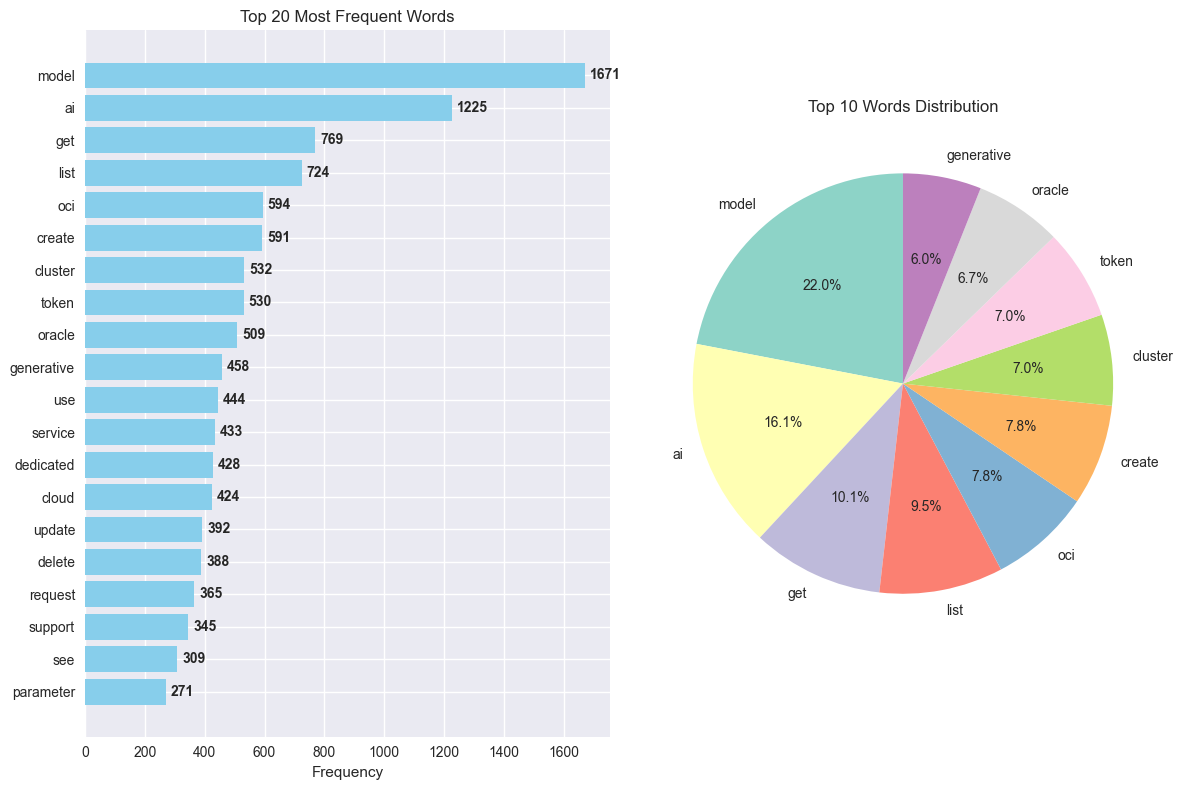


🔗 BIGRAM ANALYSIS:


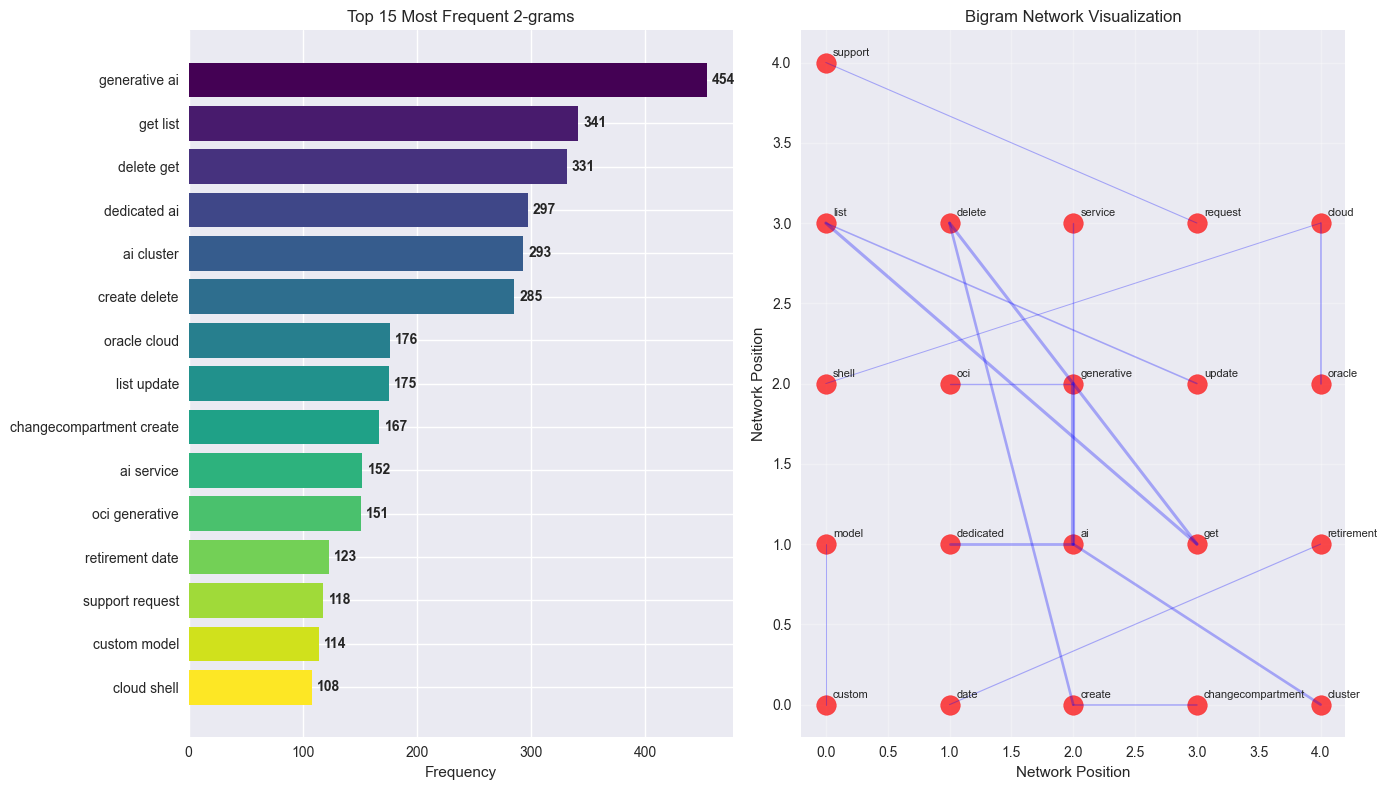


🔗🔗 TRIGRAM ANALYSIS:


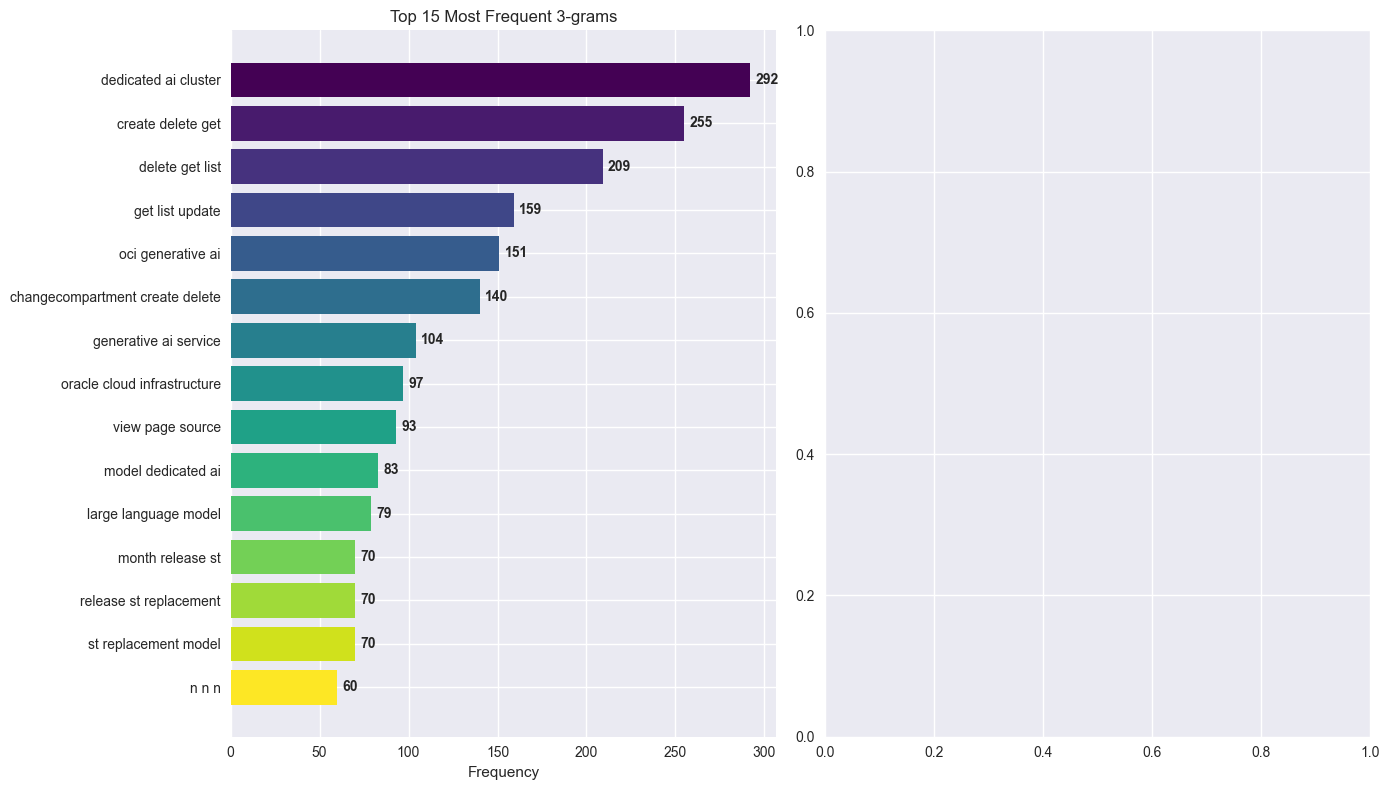


☁️ WORD CLOUD VISUALIZATION:


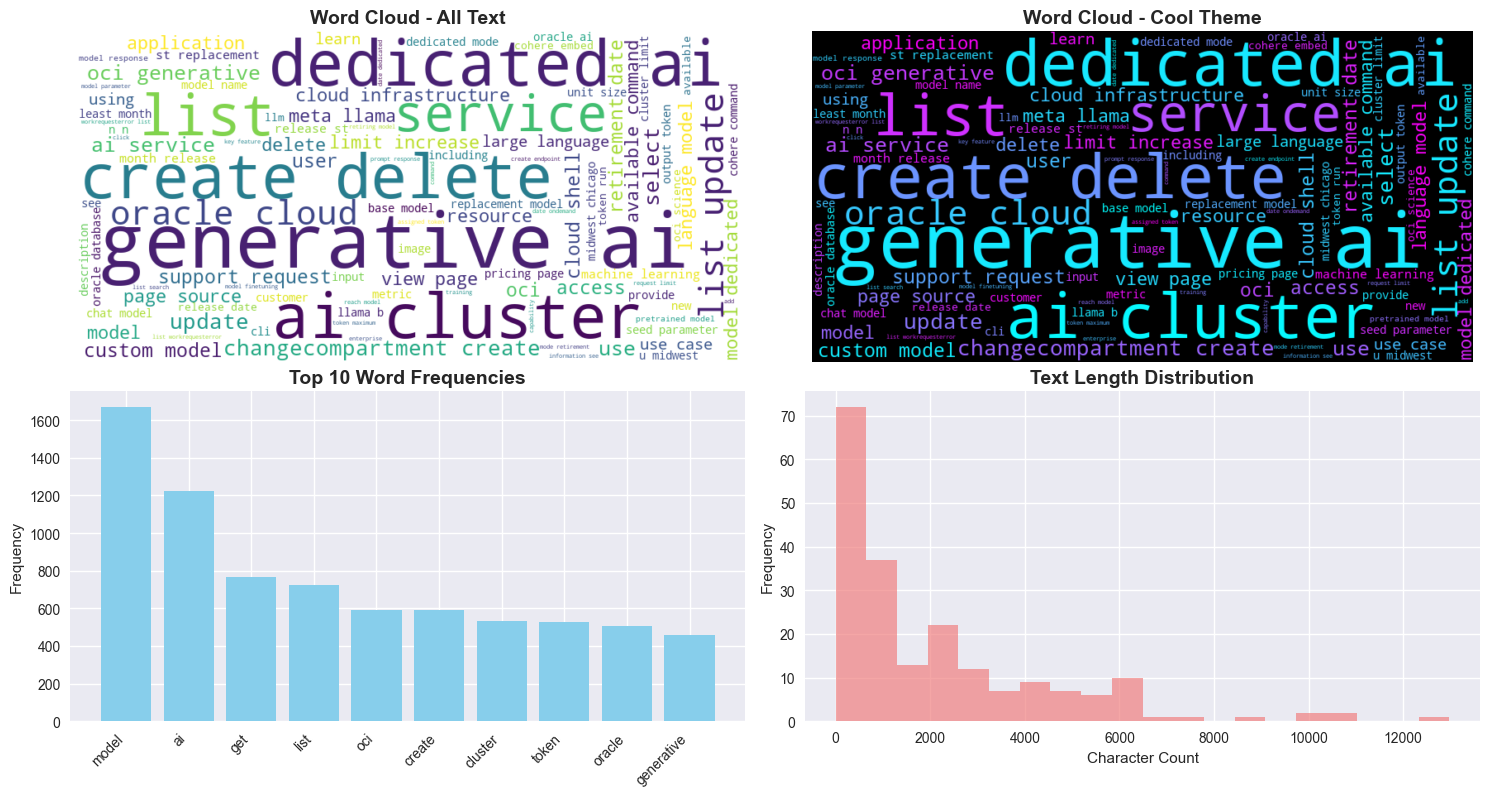


💡 ADDITIONAL INSIGHTS:
Top 5 Bigrams: ['generative ai', 'get list', 'delete get', 'dedicated ai', 'ai cluster']
Top 5 Trigrams: ['dedicated ai cluster', 'create delete get', 'delete get list', 'get list update', 'oci generative ai']

Text Length Statistics:
  Min length: 0
  Max length: 12974
  Mean length: 2128.57
  Median length: 1079.00

ANALYSIS COMPLETE!


In [ ]:
if __name__ == "__main__":
    
    # Initialize EDA
    eda = TextEDA(preprocessed, 'text_processed')
    
    # Run comprehensive analysis
    eda.comprehensive_analysis()